In [1]:
import os
import keras
import sys
import numpy as np
import pandas as pd
import os.path as osp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.externals import joblib
from sklearn.preprocessing import Normalizer, StandardScaler
sys.path.append("../")
from parse_fasta import *
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.utils import class_weight as clsw
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
import itertools
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)


%load_ext autoreload
%autoreload 2
%matplotlib inline

/Users/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def random_benchmarks(y_test):
    unique, counts = np.unique(y_test, return_counts=True)

    #computing uniformly (random guessing) class predictions
    n_samples = len(y_test)
    n_classes = len(unique)
    uniform_preds = np.random.randint(n_classes, size=n_samples)

    #computing class predictions using Naive bayes(i.e. class probs from data)
    class_probs = counts/n_samples
    naive_preds = np.random.choice(unique, size=n_samples, p=class_probs)

    return accuracy_score(y_test, uniform_preds), accuracy_score(y_test, naive_preds)

In [3]:
def bootstrap(clf2 ,X_test ,y_test, b):
    '''
    :param X: Input test data
    :param y: test labels
    :param b: number of bootstrap samples to draw (100-1000)
    :return: the standard deviation (std) aver all and per class over all bootstrap samples.
    '''

    #initilize lists to store elements
    X_test = pd.DataFrame(X_test)
    y_test = pd.DataFrame(y_test).iloc[:,0]
    
    acc_list = list()
    classes = pd.unique(y_test)

    # compute length of data set
    n = len(X_test)

    for i in range(b):

        # generate random indices and draw sample
        X_sub = X_test.sample(int(n*0.6))
        y_sub = y_test[X_sub.index]

        # compute accurace and append to list
        y_temp = clf2.predict(X_sub)
        y_temp = np.argmax(y_temp, axis=1)
        acc = accuracy_score(y_sub, y_temp)
        acc_list.append(acc)


    acc_array = np.array(acc_list)
    sd_acc = np.std(acc_array)

    return sd_acc

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("{}.png".format(title), format='png', dpi=1000)

In [5]:
def presentation_metric(clf, X_test, y_test):
    
    # Evaluate model pipeline on test data
    y_pred = clf.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    overall_acc = accuracy_score(y_test, y_pred)
    sd_acc = bootstrap(clf, X_test, y_test, 100)

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)


    class_names = np.unique(y)
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization', cmap=plt.cm.Blues)
    
    random, naive = random_benchmarks(y_test)
    
    return overall_acc, sd_acc, cnf_matrix , random , naive

# Pre-process data

In [6]:
# Load data
data_filename, data_filetype = os.path.splitext('subloc_k3_s5_eukaryota.1682.fa_1517403378041395.csv')
dataset_url = osp.join('..', 'dataset', 'subloc', 'eukaryota', data_filename+data_filetype)
df = pd.read_csv(dataset_url, sep=',')

# unique labels
labels = df.label.unique()
print(len(labels))
print(df.shape)
df[:10]

18
(1673, 8002)


,label,id,AAA,AAR,AAN,AAD,AAC,AAQ,AAE,AAG,...,VVL,VVK,VVM,VVF,VVP,VVS,VVT,VVW,VVY,VVV
0,nucleus,MPP6_YEAST,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,secreted,F19A4_HUMAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,secreted,FOLR3_HUMAN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,cytoplasm,GSKIP_HUMAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,secreted,VESP_NAJKA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,secreted,CT1A_CONMR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,secreted,CALA_CALS5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,cellmembrane,IFM3_MOUSE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,secreted,CDNF_MOUSE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,mitochondria,RM50_BOVIN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# transform labels to numerical values for preprocess
y = df['label'].values
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)

In [8]:
# STEP 1: remove datapoints belonging to classes with frequency less than threshold
ths_cls = 10
unque, counts = np.unique(y, return_counts=True)
mask = np.isin(y, np.where(counts >= ths_cls)[0])
df = df[mask]
print('New data shape: {}'.format(df.shape))

New data shape: (1654, 8002)


In [9]:
# STEP 2: remove datapoints where kmer frequency sum is less or equal to threshold
ths_kmer = 0
mask = np.sum(df.iloc[:, 2:].values, axis=1) > ths_kmer
df = df[mask]
print('New data shape: {}'.format(df.shape))

New data shape: (1502, 8002)


In [10]:
y = df['label'].values
X = df.iloc[:, 2:].values

In [11]:
# transform labels to numerical values again
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)

In [12]:
num_classes = len(np.unique(y))
num_classes

13

In [13]:
# normalize data
scaler = Normalizer().fit(X)
X = scaler.transform(X)
# zero mean
X = X - np.mean(X, axis=0)

In [14]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

## Setup model

In [15]:
def create_model(nodes=100, lr=1e-1, momentum=0.95, decay=0.0, in_dim=None, out_dim=None):
    # create model
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(in_dim,)))
    model.add(Dense(nodes, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.8)) # for bacteria 0.5
    model.add(Dense(nodes, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.8))
    model.add(Dense(out_dim, activation='softmax'))
    # Compile model
    # opt = SGD(lr=lr, momentum=momentum, decay=0.0, nesterov=False)
    opt = Adam(lr=lr, decay=decay)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

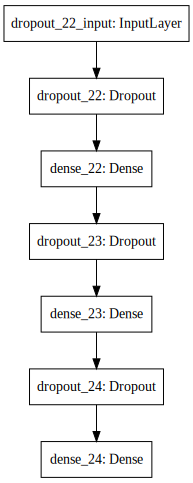

In [39]:
model = create_model(nodes=100, lr=1e-1, momentum=0.8, in_dim=X_train.shape[1], out_dim=num_classes)
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [112]:
# def load(model=None, save_filepath=None):
#     # load best weights
#     model.load_weights(osp.join('..', 'models', save_filepath))
#     return model

In [16]:
cls_weights = clsw.compute_class_weight('balanced', np.unique(y_train), y_train)
# checkpoint
checkpoint = ModelCheckpoint(filepath=osp.join('..', 'models', data_filename+'.hdf5'), monitor='val_acc', save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# for archaea mom=0.5, lr=1e-2, epochs=150
model = create_model(nodes=500, lr=1e-5, momentum=0.95, decay=0.5, in_dim=X_train.shape[1], out_dim=num_classes)

history = model.fit(X_train, y_train, epochs=400, validation_split=0.2, 
          batch_size=512, verbose=2, callbacks=callbacks_list, class_weight=cls_weights)
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("acc_{}.png".format(data_filename), format='png', dpi=1000)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_{}.png".format(data_filename), format='png', dpi=1000)
plt.show()
# evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Test %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Train on 960 samples, validate on 241 samples
Epoch 1/400
 - 2s - loss: 2.5555 - acc: 0.1177 - val_loss: 2.5438 - val_acc: 0.3693
Epoch 2/400
 - 1s - loss: 2.5332 - acc: 0.1958 - val_loss: 2.5330 - val_acc: 0.3734
Epoch 3/400
 - 1s - loss: 2.5206 - acc: 0.2354 - val_loss: 2.5253 - val_acc: 0.3734
Epoch 4/400
 - 1s - loss: 2.5108 - acc: 0.2698 - val_loss: 2.5191 - val_acc: 0.3734
Epoch 5/400
 - 1s - loss: 2.4988 - acc: 0.2927 - val_loss: 2.5138 - val_acc: 0.3734
Epoch 6/400
 - 1s - loss: 2.4911 - acc: 0.2844 - val_loss: 2.5092 - val_acc: 0.3734
Epoch 7/400
 - 1s - loss: 2.4863 - acc: 0.3115 - val_loss: 2.5052 - val_acc: 0.3734
Epoch 8/400
 - 1s - loss: 2.4818 - acc: 0.3031 - val_loss: 2.5014 - val_acc: 0.3734
Epoch 9/400
 - 1s - loss: 2.4753 - acc: 0.3292 - val_loss: 2.4981 - val_acc: 0.3734
Epoch 10/400
 - 1s - loss: 2.4767 - acc: 0.3229 - val_loss: 2.4950 - val_acc: 0.3734
Epoch 11/400
 - 1s - loss: 2.4694 - acc: 0.3260 - val_loss: 2.4921 - val_acc: 0.3734
Epoch 12/400
 - 1s - loss: 2

KeyboardInterrupt: 

In [ ]:
# cls_weights = clsw.compute_class_weight('balanced', np.unique(y_train), y_train)
# # checkpoint
# checkpoint = ModelCheckpoint(filepath=osp.join('..', 'models', data_filename+'.hdf5'), monitor='val_acc', save_best_only=True, mode='max')
# callbacks_list = [checkpoint]

# model = create_model(nodes=100, lr=1e-1, momentum=0.8, in_dim=X_train.shape[1], out_dim=num_classes)

# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
# cvscores = []
# for train, test in kfold.split(X_train, y_train):
#     # Fit the model
#     history = model.fit(X_train[train], y_train[train], epochs=100, validation_split=0.2, 
#               batch_size=256, verbose=0, callbacks=callbacks_list, class_weight=cls_weights)
# #     # summarize history for accuracy
# #     plt.plot(history.history['acc'])
# #     plt.plot(history.history['val_acc'])
# #     plt.title('model accuracy')
# #     plt.ylabel('accuracy')
# #     plt.xlabel('epoch')
# #     plt.legend(['train', 'val'], loc='upper left')
# #     plt.show()
# #     # summarize history for loss
# #     plt.plot(history.history['loss'])
# #     plt.plot(history.history['val_loss'])
# #     plt.title('model loss')
# #     plt.ylabel('loss')
# #     plt.xlabel('epoch')
# #     plt.legend(['train', 'val'], loc='upper left')
# #     plt.show()
#     # evaluate the model
#     scores = model.evaluate(X_train[test], y_train[test], verbose=0)
#     print("val %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
#     cvscores.append(scores[1] * 100)
# print("average val %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

In [73]:
# model = create_model(in_dim=X_train.shape[1], out_dim=num_classes)
# load(model, save_filepath=osp.join('..', 'models', data_filename+'.hdf5'))

Confusion matrix, without normalization


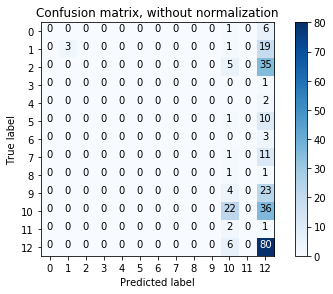

In [35]:
overall_acc, sd_acc, cnf_matrix, random_acc, naive_acc = presentation_metric(model, X_test, y_test)

In [36]:
overall_acc, sd_acc, cnf_matrix, random_acc, naive_acc

(0.38181818181818183,
 0.01909466052607536,
 array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  6],
        [ 0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0, 19],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5,  0, 35],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0, 10],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0, 11],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0, 23],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 22,  0, 36],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  0, 80]]),
 0.09454545454545454,
 0.19636363636363635)

In [ ]:
# # https://dzubo.github.io/machine-learning/2017/05/25/increasing-model-accuracy-by-tuning-parameters.html
# nodes = [100]
# lrs = [1e-1]
# mom = [0.8]
# epochs = 60
# batch_size = 256
# param_grid = dict(nodes=nodes, lr=lrs, momentum=mom)
# model = KerasClassifier(build_fn=create_model(in_dim=X_train.shape[1], out_dim=num_classes), epochs=epochs,
#                         batch_size=batch_size, verbose=0)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5,
#                     n_jobs=1, refit=True, verbose=2)
# grid_result = grid.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))